# Part2. CRF Model

## Setting and Import

In [ ]:
# Global variables
ROUND = 103

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

## Preprocessing

In [ ]:
file_path = '/content/drive/MyDrive/nlp_data_2/train_new.txt'

In [ ]:
def loadInputFile(path):
    trainingset = list()  # store trainingset [content,content,...]
    position = list()  # store position [article_id, start_pos, end_pos, entity_text, entity_type, ...]
    mentions = dict()  # store mentions[mention] = Type
    with open(file_path, 'r', encoding='utf8') as f:
        file_text=f.read().encode('utf-8').decode('utf-8-sig')
    datas=file_text.split('\n\n--------------------\n\n')[:-1]
    for data in datas:
        data=data.split('\n')
        content=data[0]
        trainingset.append(content)
        annotations=data[1:]
        for annot in annotations[1:]:
            annot=annot.split('\t') #annot= article_id, start_pos, end_pos, entity_text, entity_type
            position.extend(annot)
            mentions[annot[3]]=annot[4]
    
    return trainingset, position, mentions

In [ ]:
def CRFFormatData(trainingset, position, path):
    if (os.path.isfile(path)):
        os.remove(path)
    outputfile = open(path, 'a', encoding= 'utf-8')

    # output file lines
    count = 0 # annotation counts in each content
    tagged = list()
    for article_id in range(len(trainingset)):
        trainingset_split = list(trainingset[article_id])
        while '' or ' ' in trainingset_split:
            if '' in trainingset_split:
                trainingset_split.remove('')
            else:
                trainingset_split.remove(' ')
        start_tmp = 0
        for position_idx in range(0,len(position),5):
            if int(position[position_idx]) == article_id:
                count += 1
                if count == 1:
                    start_pos = int(position[position_idx+1])
                    end_pos = int(position[position_idx+2])
                    entity_type=position[position_idx+4]
                    if start_pos == 0:
                        token = list(trainingset[article_id][start_pos:end_pos])
                        whole_token = trainingset[article_id][start_pos:end_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            # BIO states
                            if token_idx == 0:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                            
                            output_str = token[token_idx] + ' ' + label + '\n'
                            outputfile.write(output_str)

                    else:
                        token = list(trainingset[article_id][0:start_pos])
                        whole_token = trainingset[article_id][0:start_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            
                            output_str = token[token_idx] + ' ' + 'O' + '\n'
                            outputfile.write(output_str)

                        token = list(trainingset[article_id][start_pos:end_pos])
                        whole_token = trainingset[article_id][start_pos:end_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            # BIO states
                            if token[0] == '':
                                if token_idx == 1:
                                    label = 'B-'+entity_type
                                else:
                                    label = 'I-'+entity_type
                            else:
                                if token_idx == 0:
                                    label = 'B-'+entity_type
                                else:
                                    label = 'I-'+entity_type

                            output_str = token[token_idx] + ' ' + label + '\n'
                            outputfile.write(output_str)

                    start_tmp = end_pos
                else:
                    start_pos = int(position[position_idx+1])
                    end_pos = int(position[position_idx+2])
                    entity_type=position[position_idx+4]
                    if start_pos<start_tmp:
                        continue
                    else:
                        token = list(trainingset[article_id][start_tmp:start_pos])
                        whole_token = trainingset[article_id][start_tmp:start_pos]
                        for token_idx in range(len(token)):
                            if len(token[token_idx].replace(' ','')) == 0:
                                continue
                            output_str = token[token_idx] + ' ' + 'O' + '\n'
                            outputfile.write(output_str)

                    token = list(trainingset[article_id][start_pos:end_pos])
                    whole_token = trainingset[article_id][start_pos:end_pos]
                    for token_idx in range(len(token)):
                        if len(token[token_idx].replace(' ','')) == 0:
                            continue
                        # BIO states
                        if token[0] == '':
                            if token_idx == 1:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                        else:
                            if token_idx == 0:
                                label = 'B-'+entity_type
                            else:
                                label = 'I-'+entity_type
                        
                        output_str = token[token_idx] + ' ' + label + '\n'
                        outputfile.write(output_str)
                    start_tmp = end_pos

        token = list(trainingset[article_id][start_tmp:])
        whole_token = trainingset[article_id][start_tmp:]
        for token_idx in range(len(token)):
            if len(token[token_idx].replace(' ','')) == 0:
                continue

            
            output_str = token[token_idx] + ' ' + 'O' + '\n'
            outputfile.write(output_str)

        count = 0
    
        output_str = '\n'
        outputfile.write(output_str)
        ID = trainingset[article_id]

        if article_id%10 == 0:
            print('Total complete articles:', article_id)

    # close output file
    outputfile.close()

In [ ]:
trainingset, position, mentions=loadInputFile(file_path)

In [ ]:
data_path='output.tsv'
CRFFormatData(trainingset, position, data_path)

Total complete articles: 0
Total complete articles: 10
Total complete articles: 20
Total complete articles: 30
Total complete articles: 40
Total complete articles: 50
Total complete articles: 60
Total complete articles: 70
Total complete articles: 80
Total complete articles: 90
Total complete articles: 100
Total complete articles: 110
Total complete articles: 120
Total complete articles: 130
Total complete articles: 140
Total complete articles: 150
Total complete articles: 160
Total complete articles: 170
Total complete articles: 180
Total complete articles: 190
Total complete articles: 200


In [ ]:
def Dataset(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        data=f.readlines()#.encode('utf-8').decode('utf-8-sig')
    data_list, data_list_tmp = list(), list()
    article_id_list=list()
    idx=0
    for row in data:
        data_tuple = tuple()
        if row == '\n':
            article_id_list.append(idx)
            idx+=1
            data_list.append(data_list_tmp)
            data_list_tmp = []
        else:
            row = row.strip('\n').split(' ')
            data_tuple = (row[0], row[1])
            data_list_tmp.append(data_tuple)
    if len(data_list_tmp) != 0:
        data_list.append(data_list_tmp)

    return data_list, article_id_list 

In [ ]:
traindata_list, traindata_article_id_list = Dataset(data_path)

## Get LSTM Model Input Feature

In [ ]:
# 查看總共有哪些 label
tags = list(set([tag[1] for article in traindata_list for tag in article]))
# 標籤數量
n_tags = len(tags)
# 標籤與 index 轉換
tag2idx = {t:i for i, t in enumerate(tags)}

In [ ]:
!pip install transformers
clear_output()

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from keras.utils import to_categorical
import random

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
bert_model = BertModel.from_pretrained('bert-base-chinese')

def split_sentence(data_list):
    # final word vector list
    new_sentence_list = list()
    for idx_list in range(len(data_list)):
        sentence_list = [each[0] for each in data_list[idx_list]]
        while len(sentence_list) > 512:
            new_sentence_list.append(sentence_list[:512])
            sentence_list = sentence_list.copy()[512:]
        new_sentence_list.append(sentence_list)
    return new_sentence_list

def split_tag(data_list):
    new_tag_list = list()
    for idx_list in range(len(data_list)):
        tag_list = [each[1] for each in data_list[idx_list]]
        while len(tag_list) > 512:
            new_tag_list.append(tag_list[:512])
            tag_list = tag_list.copy()[512:]
        new_tag_list.append(tag_list)
    return new_tag_list

def get_tag(new_tag_list):
    res_y_list = list()
    for tag in new_tag_list:
        # Handle tag
        while len(tag) < 512:
            tag.append("O")
        tag = [tag2idx[t] for t in tag]
        tag = to_categorical(tag, num_classes=n_tags)
        res_y_list.append(tag)
    return res_y_list

In [ ]:
# 取得切割過後的句子與標籤
new_sentence_list = split_sentence(traindata_list)
new_tag_list = split_tag(traindata_list)

In [ ]:
def get_lstm_x(new_sentence_list):
    i = 0
    for sentence in new_sentence_list:
        # get word embedding lists and tags with generator
        # Handle char to embedding
        inputs = [tokenizer.convert_tokens_to_ids(text) for text in list(sentence)]
        padding_num = 512 - len(inputs)
        input_ids = torch.tensor([inputs+[0]*padding_num])
        token_type_ids = torch.tensor([[0]*512])
        attention_mask = torch.tensor([[1]*len(inputs)+[0]*padding_num])
        final_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
        outputs = bert_model(**final_inputs).last_hidden_state[0]
        word_vector_list = [word.detach().numpy() for word in outputs]
        # res_x_list.append(word_vector_list)
        i += 1
        print(f"Bert Embedding Finish: {i}/{len(new_sentence_list)}")
        yield np.array([word_vector_list])
        
def get_y(new_tag_list):
    res_y_list = list()
    # Handle tag
    for tag in new_tag_list:
        while len(tag) < 512:
            tag.append("O")
        res_y_list.append(tag)
    return res_y_list

In [ ]:
lstm_x_train = get_lstm_x(new_sentence_list)
y_train = get_y(new_tag_list)

## Run LSTM Prediction

In [ ]:
import numpy as np
import tensorflow
import keras
import keras.backend as K
from keras import Sequential, Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import plot_model

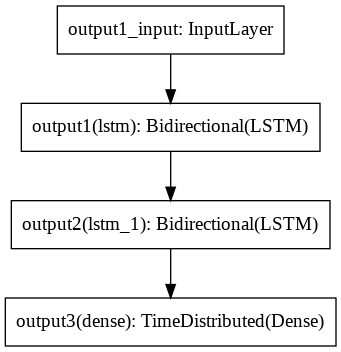

In [ ]:
bert_lstm_model = keras.models.load_model(f'/content/drive/MyDrive/nlp_data_2/lstm_model/bert_lstm_{ROUND}')
plot_model(bert_lstm_model)

In [ ]:
y_pred = bert_lstm_model.predict_generator(lstm_x_train, verbose=1, steps=len(new_sentence_list))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Bert Embedding Finish: 1/936
936/936 [==============================] - 1795s 2s/step


In [ ]:
np.save(f'/content/drive/MyDrive/nlp_data_2/lstm_train_predict/lstm_predict_{ROUND}_7', y_pred)

In [ ]:
# y_pred = np.load(f'/content/drive/MyDrive/nlp_data_2/lstm_train_predict/lstm_predict_{ROUND}.npy')

## Prepare CRF Model Input

In [ ]:
def get_crf_x(new_sentence_list, y_pred):
    # iterate 每個句子
    for idx_list in range(len(y_pred)):
        # 取得整個句子的 bert embedding vector
        sentence = new_sentence_list[idx_list]
        # 對句子中的每個字元建立 dict
        feature_list = list()
        # iterate 每個字
        for idx_tuple in range(len(y_pred[idx_list])):
            feature_dict = dict()
            # lstm output 特徵
            for idx_vec in range(len(y_pred[idx_list][idx_tuple])):
                feature_dict['lstm_dim_' + str(idx_vec)] = y_pred[idx_list][idx_tuple][idx_vec]
            # bert embedding 特徵
            # for idx_vec in range(len(word_vector_list[idx_tuple])):
            #     feature_dict['bert_dim_' + str(idx_vec)] = word_vector_list[idx_tuple][idx_vec]
            # one-gram, bigram and trigram 字元特徵
            for i in range(-3, 4):
                if len(sentence) > idx_tuple+i+2 > idx_tuple+i >= 0:
                    feature_dict['char_at_' + str(i)] = sentence[idx_tuple+i]
                    feature_dict['bigram_char_at_' + str(i)] = sentence[idx_tuple+i] + sentence[idx_tuple+i+1]
                    feature_dict['trigram_char_at_' + str(i)] = sentence[idx_tuple+i] + sentence[idx_tuple+i+1] + sentence[idx_tuple+i+2]
            feature_list.append(feature_dict)
        print(f"Finish prepare train x: {idx_list}/{len(y_pred)}")
        yield feature_list

In [ ]:
crf_x_train = get_crf_x(new_sentence_list, y_pred)

## Train CRF Model





In [ ]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 14.6MB/s 


In [ ]:
import scipy.stats
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report

from itertools import chain

import nltk
import sklearn
from sklearn.metrics import make_scorer

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    # c1=0.07,
    # c2=6e-05,
    # verbose=True,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(crf_x_train, y_train)

labels = list(crf.classes_)
labels.remove('O')
labels

Finish prepare train x: 0/936
Finish prepare train x: 1/936
Finish prepare train x: 2/936
Finish prepare train x: 3/936
Finish prepare train x: 4/936
Finish prepare train x: 5/936
Finish prepare train x: 6/936
Finish prepare train x: 7/936
Finish prepare train x: 8/936
Finish prepare train x: 9/936
Finish prepare train x: 10/936
Finish prepare train x: 11/936
Finish prepare train x: 12/936
Finish prepare train x: 13/936
Finish prepare train x: 14/936
Finish prepare train x: 15/936
Finish prepare train x: 16/936
Finish prepare train x: 17/936
Finish prepare train x: 18/936
Finish prepare train x: 19/936
Finish prepare train x: 20/936
Finish prepare train x: 21/936
Finish prepare train x: 22/936
Finish prepare train x: 23/936
Finish prepare train x: 24/936
Finish prepare train x: 25/936
Finish prepare train x: 26/936
Finish prepare train x: 27/936
Finish prepare train x: 28/936
Finish prepare train x: 29/936
Finish prepare train x: 30/936
Finish prepare train x: 31/936
Finish prepare tra

['B-time',
 'I-time',
 'B-med_exam',
 'I-med_exam',
 'B-profession',
 'I-profession',
 'B-name',
 'I-name',
 'B-location',
 'I-location',
 'B-family',
 'I-family',
 'B-ID',
 'I-ID',
 'B-clinical_event',
 'I-clinical_event',
 'B-education',
 'I-education',
 'B-money',
 'I-money',
 'B-contact',
 'I-contact',
 'B-organization',
 'I-organization',
 'B-others',
 'I-others']

In [ ]:
# 找最佳參數
# define fixed parameters and parameters to search
# crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )

# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

# rs = RandomizedSearchCV(crf, params_space, cv=3, verbose=1, n_jobs=-1, n_iter=10, scoring=f1_scorer, )
# rs.fit(crf_x_train[:65], y_train[:65])

In [ ]:
# crf = rs.best_estimator_
# print('best params:', rs.best_params_)
# print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

# best params: {'c1': 0.07331793199832798, 'c2': 6.314488709135739e-05}
# best CV score: 0.849530972881435
# model size: 0.07M

In [ ]:
# y_pred = crf.predict(crf_x_train)
# metrics.flat_f1_score(y_train, y_pred, average='weighted', labels=labels)

In [ ]:
# # group B and I results
# sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
# print(metrics.flat_classification_report(y_train, y_pred, labels=sorted_labels, digits=3))

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = f"/content/drive/MyDrive/nlp_data_2/crf_model/crf_model_{ROUND}_7.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(crf, file) 